<a href="https://colab.research.google.com/github/octaviareika/CalculaData/blob/master/Apresentacao-disciplina/Agentes-implementacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementação - Smart house**

A seguir, vamos apresentar a implementação de uma possível funcionalidade de uma *smart house*

Imagine que a implementação controle o estoque de papel higiênico da sua casa (república). O sistema mantém uma quantidade mínima de papel e tenta comprar os produtos a um preço baixo.

# Importar bibliotecas necessárias para executar o código


In [1]:
from random import *
import matplotlib.pyplot as plt
import numpy as np

# Definição do ambiente

Vamos armazenar no ambiente as seguintes informações:

*   Informação do dia
*   Preço do produto em cada um dos dias da série
*   Histórico de preços
*   Histórico de estoque
*   Histórico com a quantidade de produtos comprados

In [2]:

class Ambiente:
    def __init__(self):
        self.num_dias = 0
        self.bateria = 300  # Nível inicial da bateria (kWh)
        self.capacidade = 500  # Capacidade máxima da bateria (kWh)
        self.historico_preco = [uniform(0.5, 2.0)]  # Preço inicial da energia (R$/kWh)
        self.historico_bateria = [self.bateria]  # Histórico do nível da bateria
        self.historico_consumo = []  # Histórico do consumo diário

    def percebe_preco_atual(self):
        return self.historico_preco[-1]  # Retorna o preço atual da energia

    def percebe_bateria(self):
        return self.historico_bateria[-1]  # Retorna o nível atual da bateria

    def run(self, dic_acoes):
        consumo_diario = randint(200, 400)  # Consumo diário de energia (kWh)
        bateria_atual = self.historico_bateria[-1] - consumo_diario + dic_acoes["comprar"]
        bateria_atual = max(0, min(bateria_atual, self.capacidade))  # Limita a bateria entre 0 e a capacidade máxima
        self.historico_bateria.append(bateria_atual)
        self.historico_consumo.append(consumo_diario)

        if bateria_atual <= 0:
            print("Bateria esgotada! Data center desliga.")
            return False

        novo_preco = uniform(0.5, 2.0)  # Novo preço da energia
        self.historico_preco.append(novo_preco)
        return True


# Definição do agente

O agente vai armazenar informações sobre:
*   Ambiente (Composição de classes)
*   Valor médio das compras
*   Informação do último valor do produto
*   Informação sobre o estoque atual de produtos na casa

In [3]:
class Agente:
    def __init__(self, ambiente):
        self.num_dias = 1
        self.ambiente = ambiente
        self.bateria = ambiente.percebe_bateria()
        self.total_gasto = 0
        self.preco_atual = self.media_simples = ambiente.percebe_preco_atual()
        self.historico_precos = [self.preco_atual]

    def calcula_media_movel(self, ultimos_dias=5):
        if len(self.historico_precos) < ultimos_dias:
            return self.media_simples
        else:
            return sum(self.historico_precos[-ultimos_dias:]) / ultimos_dias

    def executa_agente(self, qtde_dias=100, estrategia="simples"):
        for i in range(qtde_dias):
            self.bateria = self.ambiente.percebe_bateria()
            self.preco_atual = self.ambiente.percebe_preco_atual()
            self.historico_precos.append(self.preco_atual)

            if estrategia == "simples":
                referencia = self.media_simples
            elif estrategia == "movel":
                referencia = self.calcula_media_movel()

            # Decisão de compra
            if self.bateria < 200:
                compra = min(400, self.ambiente.capacidade - self.bateria)  # Compra máxima de 400 kWh
            # se o valor atual ta abaixo da média simples ou móvel
            elif self.preco_atual < referencia:
                compra = min(400, self.ambiente.capacidade - self.bateria)  # Compra máxima de 400 kWh
            else:
                compra = 0

            self.total_gasto += self.preco_atual * compra  # Calcula o total gasto
            self.media_simples = (self.media_simples * (self.num_dias - 1) + self.preco_atual) / self.num_dias

            if not self.ambiente.run({"comprar": compra}):
                break

            self.num_dias += 1


# Definir classe para impressão dos resultados


In [4]:
class Imprime:
    @staticmethod
    def imprime_resultado(agente_simples, agente_movel):
        historico_dias = np.arange(1, max(agente_simples.num_dias, agente_movel.num_dias) + 1)

        # Gráfico 1: Comparação entre média simples e média móvel
        # Gráfico: Comparação entre média simples e média móvel com limites ajustados
        plt.figure(figsize=(10, 6))
        plt.plot(historico_dias[:agente_simples.num_dias], agente_simples.ambiente.historico_bateria[:agente_simples.num_dias], 'b-', label='Bateria (Média Simples)')
        plt.plot(historico_dias[:agente_movel.num_dias], agente_movel.ambiente.historico_bateria[:agente_movel.num_dias], 'g-', label='Bateria (Média Móvel)')
        plt.axhline(200, color='r', linestyle='--', label='Limite mínimo (200 kWh)')
        plt.title("Comparação do Nível da Bateria: Média Simples vs. Média Móvel")
        plt.xlabel("Dias")
        plt.ylabel("Nível da Bateria (kWh)")
        plt.xlim(0, 50)  # Define o limite do eixo x de 0 a 50
        plt.ylim(100, 500)  # Define o limite do eixo y de 100 a 500
        plt.legend()
        plt.grid()
        plt.show()

        # Gráfico 2: Histórico de consumo
        plt.figure(figsize=(10, 6))
        plt.plot(historico_dias[:len(agente_simples.ambiente.historico_consumo)], agente_simples.ambiente.historico_consumo, 'r-', label='Consumo Diário')
        plt.title("Histórico de Consumo Diário")
        plt.xlabel("Dias")
        plt.ylabel("Consumo (kWh)")
        plt.legend()
        plt.grid()
        plt.show()

        # Gráfico 3: Histórico do preço da energia
        plt.figure(figsize=(10, 6))
        plt.plot(historico_dias[:len(agente_simples.ambiente.historico_preco)], agente_simples.ambiente.historico_preco, 'b-', label='Preço da Energia')
        plt.title("Histórico do Preço da Energia")
        plt.xlabel("Dias")
        plt.ylabel("Preço (R$/kWh)")
        plt.legend()
        plt.grid()
        plt.show()



# Execução do programa

Por um determinado número de iterações, vamos gerar valores aleatórios para o preco do papel higienico e a quantidade de produto consumido

Executando com média simples...
Bateria esgotada! Data center desliga.
Executando com média móvel...
Bateria esgotada! Data center desliga.


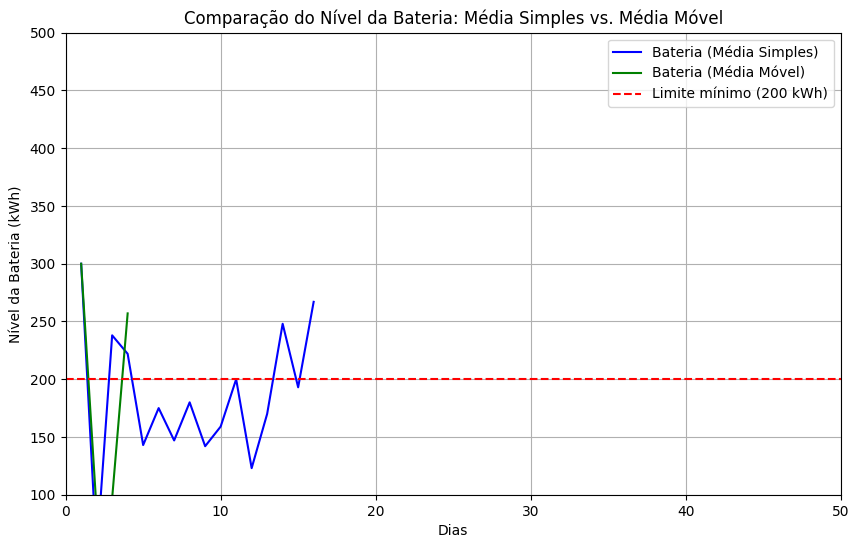

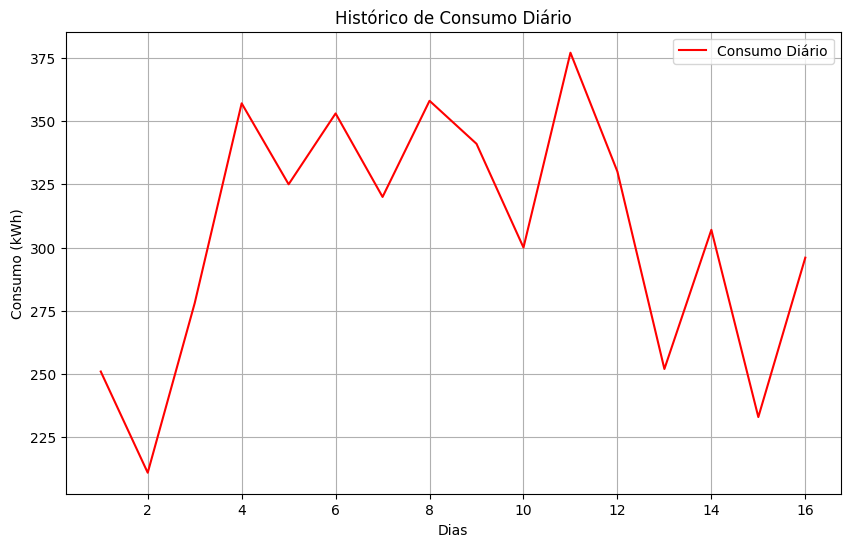

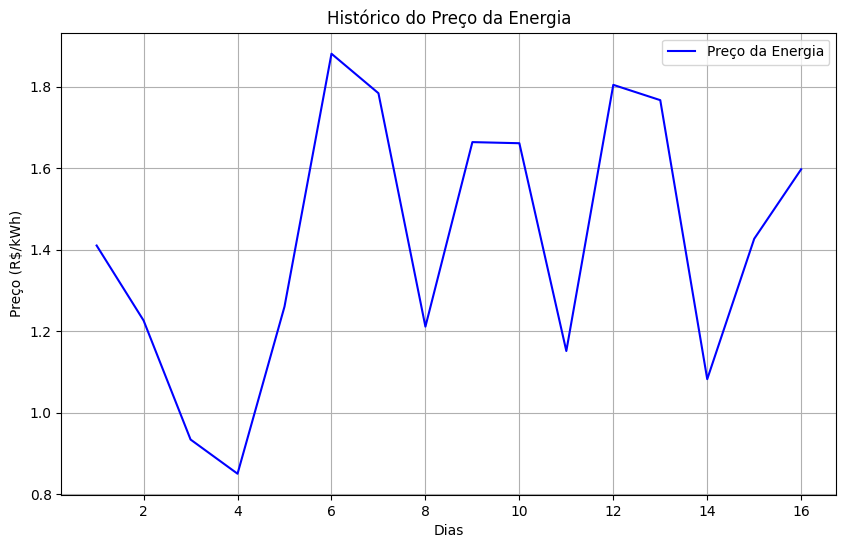

In [7]:
 # Simulação com média simples
ambiente_simples = Ambiente()
agente_simples = Agente(ambiente_simples)
print("Executando com média simples...")
agente_simples.executa_agente(qtde_dias=100, estrategia="simples")

# Simulação com média móvel
ambiente_movel = Ambiente()
agente_movel = Agente(ambiente_movel)
print("Executando com média móvel...")
agente_movel.executa_agente(qtde_dias=100, estrategia="movel")

# Imprimir resultados
Imprime.imprime_resultado(agente_simples, agente_movel)